# Import

In [1]:
import numpy as np
import healpy as hp
import pandas as pd
import networkx as nx
import geopandas as gpd

from itertools import combinations

from pyproj import Geod
from shapely import union_all, intersects
from shapely.wkt import loads
from shapely.geometry import LineString
from healpix_geo.nested import healpix_to_lonlat
from healpix_geo.nested import lonlat_to_healpix

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt

In [2]:
def get_points(NSIDE):
    NPIX = hp.nside2npix(NSIDE)
    points = np.array(
        hp.pix2vec(NSIDE, range(NPIX), nest=True)
    ).T

    df = pd.DataFrame(points, columns=('x', 'y', 'z'))

    return df

def get_patches(NSIDE):
    NPIX = hp.nside2npix(NSIDE)

    pixels = np.arange(NPIX)
    patches = np.array(
        [hp.boundaries(NSIDE, i, nest=True).T for i in pixels]
    ).reshape(-1, 3)

    df = pd.DataFrame(patches, columns=('x', 'y', 'z'))

    return df

In [57]:
def great_circle_path(a=None, b=None, n_points=100, iterable=False):
    geod = Geod(ellps='WGS84')

    if iterable:
        (a, b) = a

    points = geod.npts(
        a.x, a.y,
        b.x, b.y,
        n_points,
    )
    line = LineString(points)

    return line

def great_circle_distance(a=None, b=None, iterable=False):
    geod = Geod(ellps='WGS84')

    if iterable:
        (a, b) = a

    distance = geod.inv(
        a.x, a.y,
        b.x, b.y,
    )[2]

    return distance

# Data

## Borders

In [3]:
kaz = gpd.read_file('data/geoBoundaries-KAZ-ADM0_simplified.geojson')
ukr = gpd.read_file('data/geoBoundaries-UKR-ADM0_simplified.geojson')
rus = gpd.read_file('data/geoBoundaries-RUS-ADM0_simplified.geojson')
blr = gpd.read_file('data/geoBoundaries-BLR-ADM0_simplified.geojson')
borders = pd.concat((kaz, ukr, rus, blr)).reset_index(drop=True)
borders = borders.to_crs(epsg=4326)
borders

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,Kazakhstan,KAZ,12445969B25401373275960,KAZ,ADM0,"MULTIPOLYGON (((50.3741 44.78639, 50.37386 44...."
1,Ukraine,UKR,60985579B58127766181095,UKR,ADM0,"POLYGON ((33.19618 52.37361, 33.19572 52.37895..."
2,Russian Federation,RUS,89588193B69022144921215,RUS,ADM0,"MULTIPOLYGON (((130.82214 42.4629, 130.8202 42..."
3,Belarus,BLR,10690812B6439167788480,BLR,ADM0,"POLYGON ((31.78388 52.10805, 31.78611 52.12416..."


## Airports

In [4]:
airports = pd.read_csv('data/airports.csv')
airports = gpd.GeoDataFrame(
    airports.drop(['GeoPointLat', 'GeoPointLong'], axis=1),
    geometry=gpd.points_from_xy(
        *airports[['GeoPointLong', 'GeoPointLat']].values.T
    ), crs='EPSG:4326'
)
airports[airports.ICAO.isin(['KJFK', 'UAAA'])]

,AirportName,IATA,ICAO,TimeZone,City_Name,City_IATA,UTC_Offset_Hours,UTC_Offset_Seconds,Country_CodeA2,Country_CodeA3,Country_Name,geometry
2169,John F Kennedy Intl,JFK,KJFK,America/New_York,"New York, New York",NYC,-4.0,-14400.0,US,USA,United States of America,POINT (-73.77892 40.63975)
5300,Almaty,ALA,UAAA,Asia/Qyzylorda,Almaty,ALA,5.0,18000.0,KZ,KAZ,Kazakhstan,POINT (77.04051 43.35207)


# HEALPix

In [5]:
NSIDE = 16
healpix = get_points(NSIDE)

NPIX = hp.nside2npix(NSIDE)
ipix = np.arange(NPIX)
depth = np.log2(NSIDE).astype(int)

print(NPIX, depth)

3072 4


In [13]:
lon, lat = healpix_to_lonlat(ipix, depth=depth, ellipsoid='WGS84')
lon = (lon + 180) % 360 - 180

In [14]:
gdf = gpd.GeoDataFrame(
    healpix,
    geometry=gpd.points_from_xy(
        lon, lat
    ),
    crs='EPSG:4326',
)
gdf

,x,y,z,geometry
0,0.706493,0.706493,0.041667,POINT (45 2.39873)
1,0.669223,0.738374,0.083333,POINT (47.8125 4.80155)
2,0.738374,0.669223,0.083333,POINT (42.1875 4.80155)
3,0.701561,0.701561,0.125000,POINT (45 7.21266)
4,0.629418,0.766948,0.125000,POINT (50.625 7.21266)
...,...,...,...,...
3067,0.629418,-0.766948,-0.125000,POINT (-50.625 -7.21266)
3068,0.701561,-0.701561,-0.125000,POINT (-45 -7.21266)
3069,0.738374,-0.669223,-0.083333,POINT (-42.1875 -4.80155)
3070,0.669223,-0.738374,-0.083333,POINT (-47.8125 -4.80155)


In [6]:
start = lonlat_to_healpix(
    airports[airports.ICAO=='UAAA'].geometry.x,
    airports[airports.ICAO=='UAAA'].geometry.y,
    depth,
    ellipsoid='WGS84',
)[0]
end = lonlat_to_healpix(
    airports[airports.ICAO=='KJFK'].geometry.x,
    airports[airports.ICAO=='KJFK'].geometry.y,
    depth,
    ellipsoid='WGS84',
)[0]

In [7]:
df = pd.read_csv('point_pairs_full.csv', index_col=False)
df = df[~df.intersect_avoid].reset_index()
df

,index,point_a,point_b,path,intersect_avoid,healpix_id_a,healpix_id_b,distance
0,0,POINT (45 2.3987250992841447),POINT (47.8125 4.801554594177967),LINESTRING (45.055020515638404 2.4459152101302...,False,0,1,4.101488e+05
1,1,POINT (45 2.3987250992841447),POINT (42.1875 4.801554594177967),LINESTRING (44.944979484361596 2.4459152101302...,False,0,2,4.101488e+05
2,2,POINT (45 2.3987250992841447),POINT (45 7.212658108949127),"LINESTRING (45 2.4931214185652424, 45 2.587517...",False,0,3,5.323378e+05
3,3,POINT (45 2.3987250992841447),POINT (50.625 7.212658108949127),LINESTRING (45.109656950531374 2.4934954503132...,False,0,4,8.200651e+05
4,4,POINT (45 2.3987250992841447),POINT (53.4375 9.636338620241146),LINESTRING (45.1637069675639 2.541664115293592...,False,0,5,1.229631e+06
...,...,...,...,...,...,...,...,...
3695545,4094086,POINT (-45 -7.212658108949127),POINT (-47.8125 -4.801554594177967),LINESTRING (-45.055400500283824 -7.16553202138...,False,3068,3070,4.099221e+05
3695546,4094087,POINT (-45 -7.212658108949127),POINT (-45 -2.3987250992841447),"LINESTRING (-45 -7.11827481121803, -45 -7.0238...",False,3068,3071,5.323378e+05
3695547,4094088,POINT (-42.1875 -4.801554594177967),POINT (-47.8125 -4.801554594177967),LINESTRING (-42.297792946608595 -4.80200065705...,False,3069,3070,6.239875e+05
3695548,4094089,POINT (-42.1875 -4.801554594177967),POINT (-45 -2.3987250992841447),LINESTRING (-42.24280404901021 -4.754534435995...,False,3069,3071,4.101488e+05


# Graph

In [8]:
G = nx.from_edgelist(
    df[['healpix_id_a', 'healpix_id_b']].values
)

In [21]:
for idx, row in df.iterrows():
    G[row.healpix_id_a][row.healpix_id_b]['weight'] = row.distance

In [23]:
route = nx.astar_path(
    G, start, end,
)

In [35]:
gdf_route

,index,geometry
0,89,POINT (75.9375 41.93785)
1,99,POINT (56.25 38.80745)
2,165,POINT (19.6875 41.93785)
3,932,POINT (-73.125 38.80745)


In [42]:
airports.loc[airports.ICAO=='UAAA', 'geometry']

5300    POINT (77.04051 43.35207)
Name: geometry, dtype: geometry

In [43]:
gdf_route.loc[gdf_route.point_id=='UAAA', 'geometry']

0    None
Name: geometry, dtype: geometry

In [45]:
gdf_route = gdf.iloc[route].geometry.reset_index()
gdf_route = gdf_route.rename({'index': 'point_id'}, axis=1)
gdf_route.point_id = gdf_route.point_id.astype(str)

gdf_route.loc[gdf_route.point_id==str(start), 'point_id'] = 'UAAA'
gdf_route.loc[gdf_route.point_id=='UAAA', 'geometry'] = airports.loc[airports.ICAO=='UAAA', 'geometry'].values

gdf_route.loc[gdf_route.point_id==str(end), 'point_id'] = 'KJFK'
gdf_route.loc[gdf_route.point_id=='KJFK', 'geometry'] = airports.loc[airports.ICAO=='KJFK', 'geometry'].values

gdf_route

,point_id,geometry
0,UAAA,POINT (77.04051 43.35207)
1,99,POINT (56.25 38.80745)
2,165,POINT (19.6875 41.93785)
3,KJFK,POINT (-73.77892 40.63975)


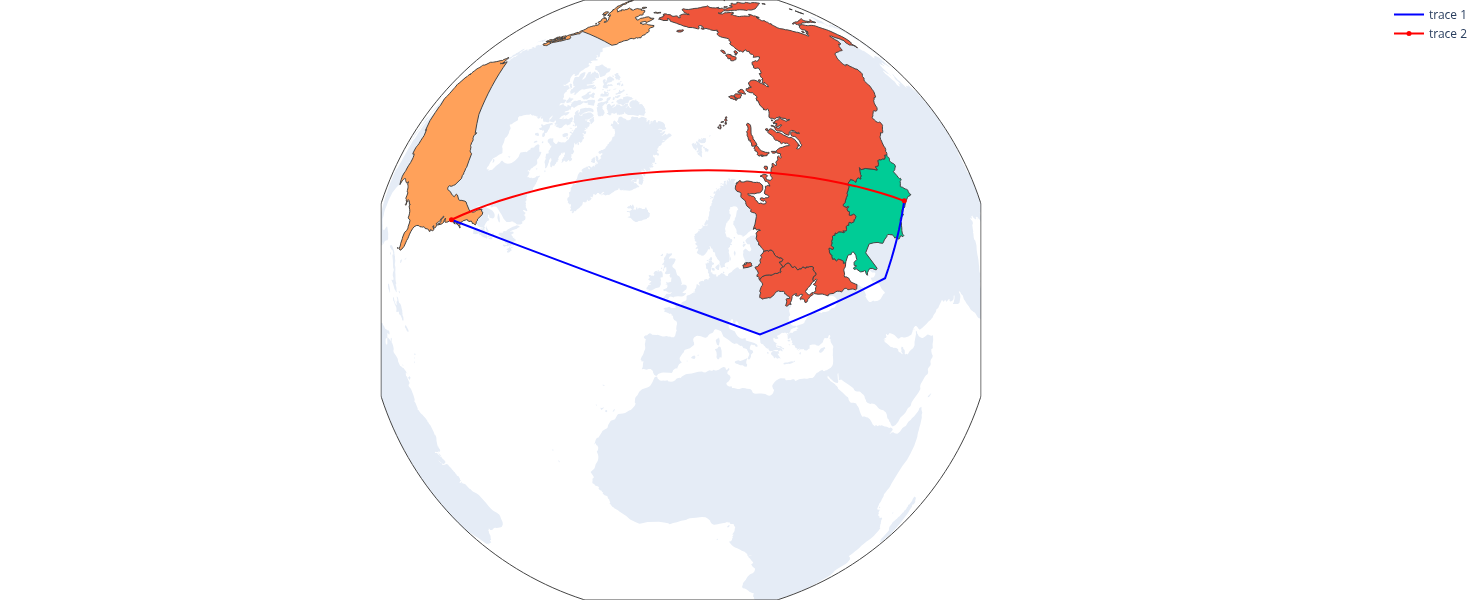

In [53]:
countries = ['KAZ', 'UKR', 'RUS', 'BLR', 'USA']

fig = go.Figure()

trace = go.Choropleth(
    locations=countries,
    z=list(range(len(countries))),
    locationmode='ISO-3',
    colorscale=np.array(px.colors.qualitative.Plotly)[[2, 1, 1, 1, 4]],
    text=countries,
    showscale=False,
)
fig.add_trace(trace)

route_trace = go.Scattergeo(
    lon=gdf_route.geometry.x,
    lat=gdf_route.geometry.y,
    mode='lines',
    marker=dict(size=1, color='blue'),
)
fig.add_trace(route_trace)

start_end = go.Scattergeo(
    lon=airports[airports.ICAO.isin(['KJFK', 'UAAA'])].geometry.x,
    lat=airports[airports.ICAO.isin(['KJFK', 'UAAA'])].geometry.y,
    mode='lines+markers',
    marker=dict(size=5, color='red'),
)
fig.add_trace(start_end)

fig.update_geos(
    fitbounds='locations',
    visible=False,
    projection_type='orthographic',
)
fig.update_layout(
    autosize=False,
    width=900, height=600,
    margin=dict(l=0, r=0, b=0, t=0),
    geo=dict(
        showframe=True,
        showland=True,
    ),
)
fig.show()

In [59]:
from pint import UnitRegistry
ureg = UnitRegistry()

In [132]:
route_segments = pd.DataFrame([
    {
        'segment': f'{window.point_id.values[0]} - {window.point_id.values[1]}',
        'distance_m': great_circle_distance(*window.geometry.values),
        'distance_nml': (
            great_circle_distance(*window.geometry.values) * ureg.meter
        ).to(ureg.nautical_mile).magnitude,
    }
    for window in gdf_route.rolling(2)
    if len(window) == 2
])
route_segments

,segment,distance_m,distance_nml
0,UAAA - 99,1.813090e+06,978.990263
1,99 - 165,3.100893e+06,1674.348315
2,165 - KJFK,7.396593e+06,3993.840684


In [149]:
print(
    f'direct UAAA-KJFK: {(
        great_circle_distance(
            *gdf_route[
                gdf_route.point_id.isin(['UAAA', 'KJFK'])
            ].geometry.values
        ) * ureg.meter
    ).to(ureg.nautical_mile).magnitude:.2f} nautical miles'
)
print(f'segmented UAAA-KJFK: {route_segments.distance_nml.sum():.2f} nautical miles')

direct UAAA-KJFK: 5536.47 nautical miles
segmented UAAA-KJFK: 6647.18 nautical miles
